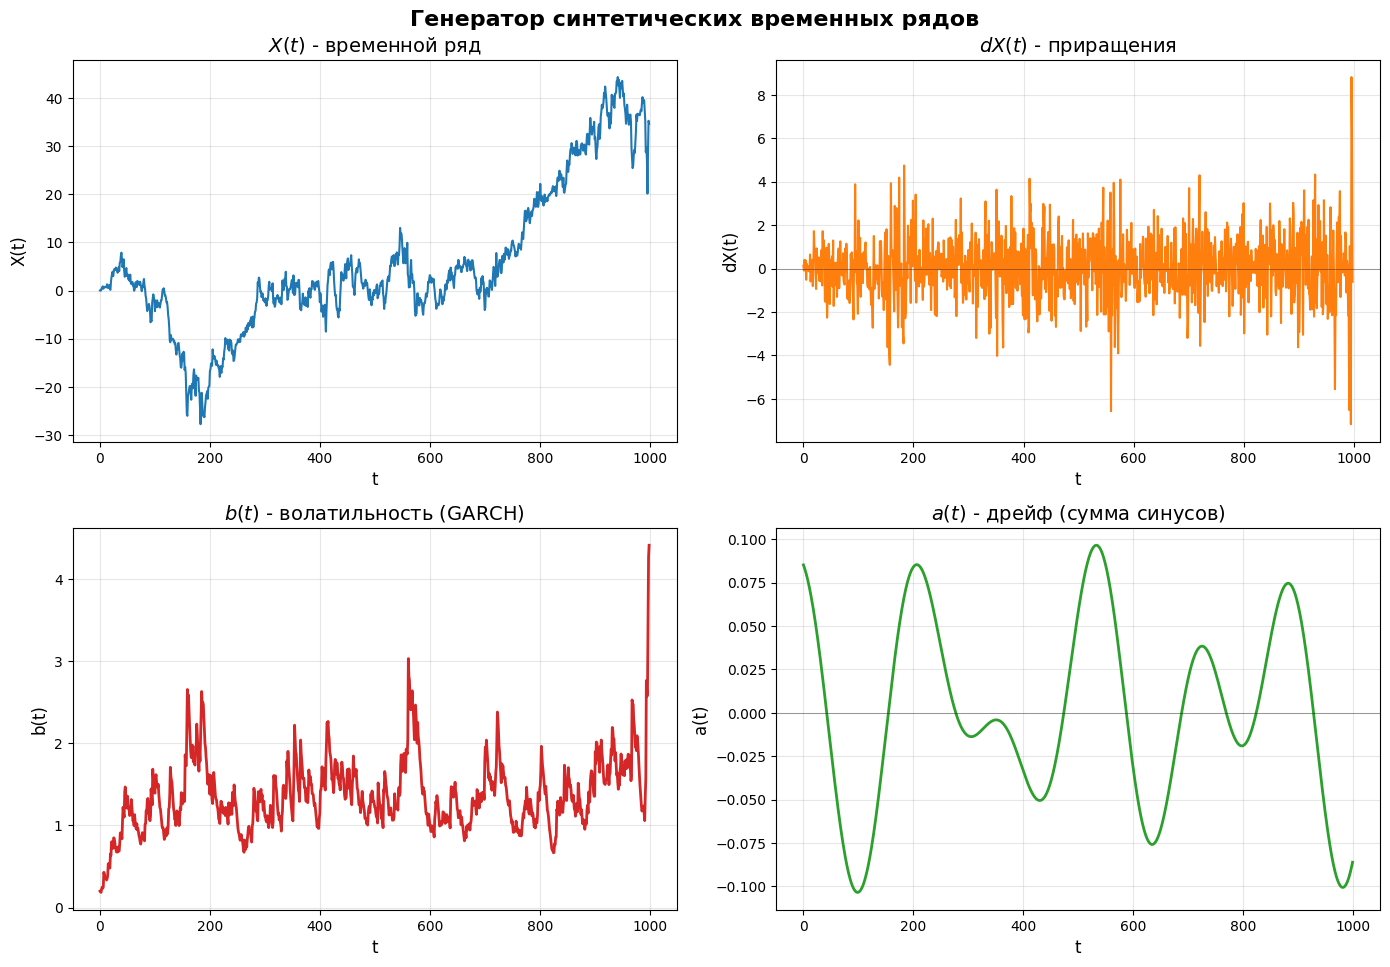

In [ ]:
from sem.generate_series import create_sde_process
from sem.sem.mixture_sem import MixtureSEM
from sem.sem.mixture_em_diff import NormalMixtureEM
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep
import torch
import numpy as np
import random

seed = 85
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
random.seed(seed)



num_components = 5
length = 1000

series_dct = create_sde_process(length, n_components=num_components)
series = series_dct['X']
deltas = series[1:] - series[:-1]
a_trafaret = series_dct['a_t']
b_trafaret = series_dct['b_t']

# plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Генератор синтетических временных рядов', fontsize=16, fontweight='bold')

# 1. Временной ряд X(t)
axes[0, 0].plot(series, color='#1f77b4', linewidth=1.5)
axes[0, 0].set_title('$X(t)$ - временной ряд', fontsize=14)
axes[0, 0].set_xlabel('t', fontsize=12)
axes[0, 0].set_ylabel('X(t)', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# 2. Приращения dX(t)
axes[0, 1].plot(deltas, color='#ff7f0e', linewidth=1.5)
axes[0, 1].set_title('$dX(t)$ - приращения', fontsize=14)
axes[0, 1].set_xlabel('t', fontsize=12)
axes[0, 1].set_ylabel('dX(t)', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

# 3. Дрейф a(t)
axes[1, 1].plot(a_trafaret, color='#2ca02c', linewidth=2)
axes[1, 1].set_title('$a(t)$ - дрейф (сумма синусов)', fontsize=14)
axes[1, 1].set_xlabel('t', fontsize=12)
axes[1, 1].set_ylabel('a(t)', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

# 4. Волатильность b(t)
axes[1, 0].plot(b_trafaret, color='#d62728', linewidth=2)
axes[1, 0].set_title('$b(t)$ - волатильность (GARCH)', fontsize=14)
axes[1, 0].set_xlabel('t', fontsize=12)
axes[1, 0].set_ylabel('b(t)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.08)
plt.show()

N = 5; Max ACF(1): 0.9999964237213135
N = 10; Max ACF(1): 0.929002583026886
N = 15; Max ACF(1): 0.9144154787063599
N = 20; Max ACF(1): 0.8289822340011597
N = 25; Max ACF(1): 0.8066887855529785
N = 30; Max ACF(1): 0.7832433581352234
N = 35; Max ACF(1): 0.7603382468223572
N = 40; Max ACF(1): 0.753075122833252
N = 45; Max ACF(1): 0.747492790222168
N = 50; Max ACF(1): 0.7408686876296997
N = 55; Max ACF(1): 0.7327196598052979
N = 60; Max ACF(1): 0.7162199020385742
N = 65; Max ACF(1): 0.716742753982544
N = 70; Max ACF(1): 0.7282934188842773
N = 75; Max ACF(1): 0.7070990800857544
N = 80; Max ACF(1): 0.6978131532669067
Found window length: 80
N = 5; Max ACF(1): 0.9999964237213135
N = 10; Max ACF(1): 0.929002583026886
N = 15; Max ACF(1): 0.9144154787063599
N = 20; Max ACF(1): 0.8289822340011597
N = 25; Max ACF(1): 0.8066887855529785
N = 30; Max ACF(1): 0.7832433581352234
N = 35; Max ACF(1): 0.7603382468223572
N = 40; Max ACF(1): 0.753075122833252
N = 45; Max ACF(1): 0.747492790222168
N = 50; Ma

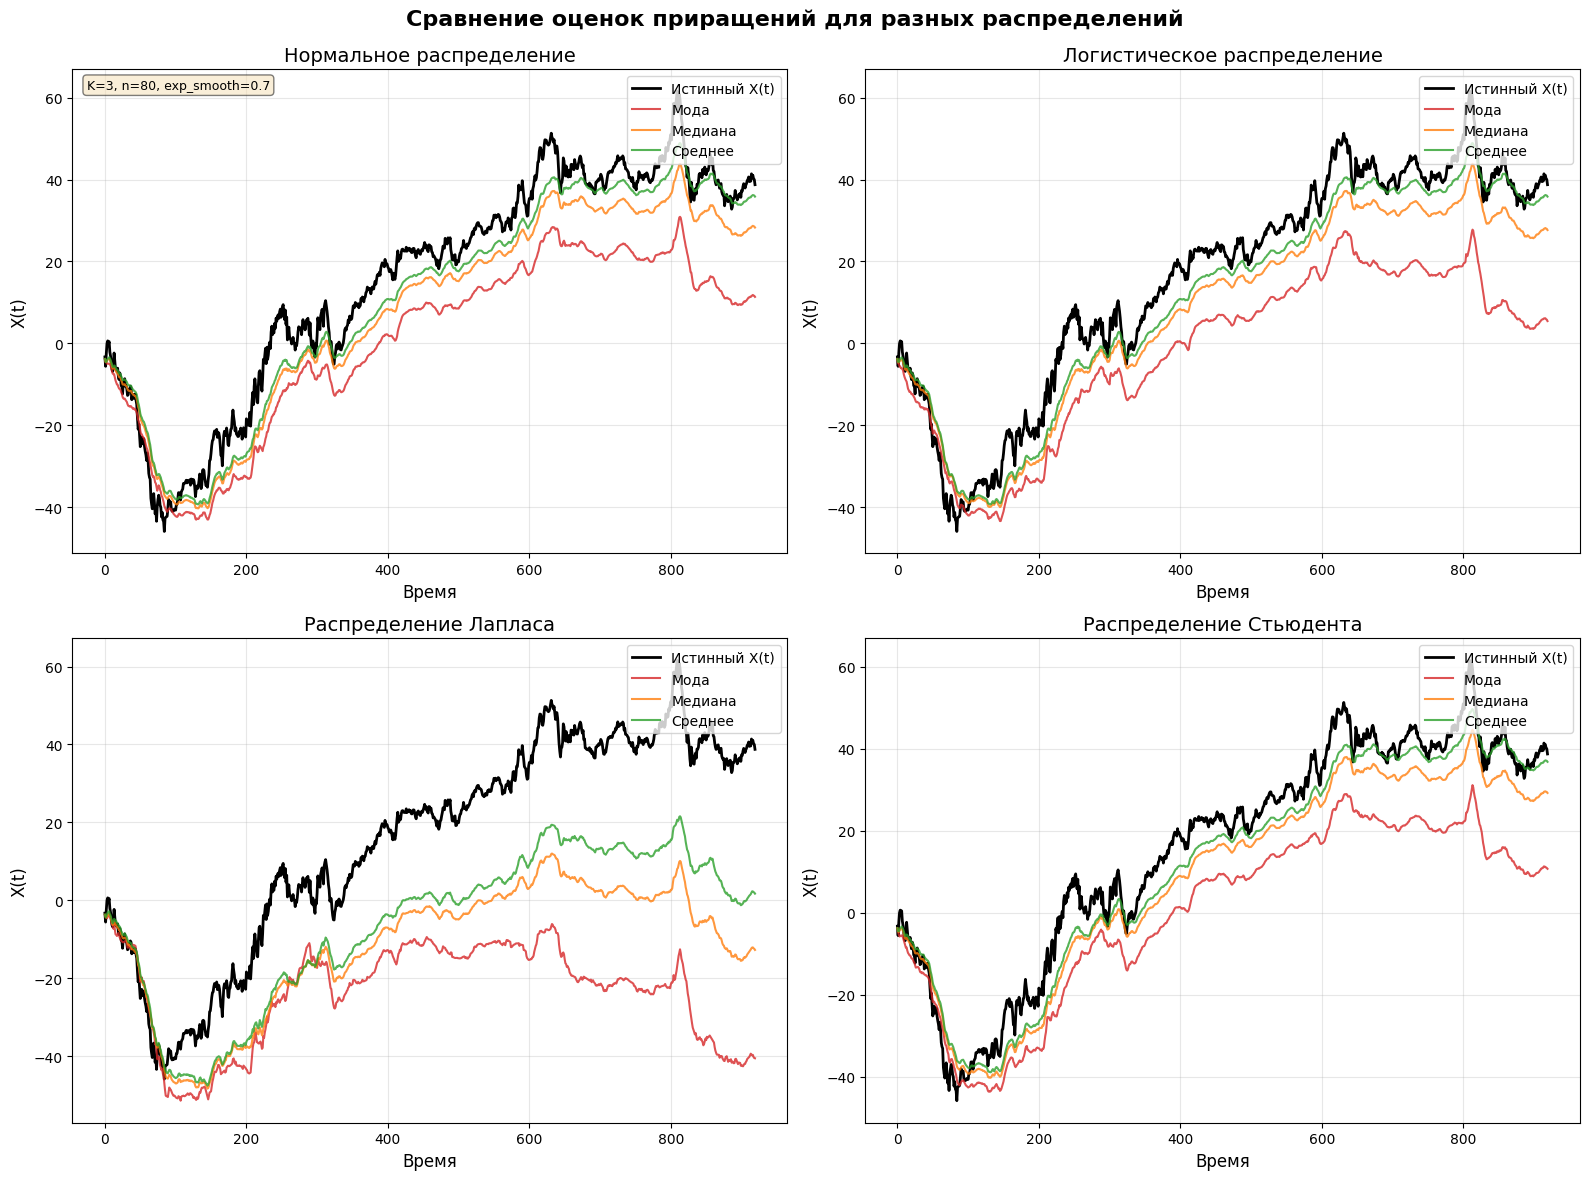

In [ ]:
x_modals = []
x_medians = []
x_means = []

distrs = ('normal', 'logistic', 'laplace', 'student')

for distr in distrs:
    sem = MixtureSEM(deltas, n_components=3, N_init=5, alpha=0.7, comp_distr=distr, exp_smooth=0.7, prior_strength=1.0, tol=1e-4, device="cpu")
    args = sem.find_params()

    g = args['g']
    a_k = args['mu']
    b_k = args['sigma']
    p_k = args['w']
    nu = None
    if 'nu' in args:
        nu = args['nu']

    p_values = torch.tensor([0.5], dtype=torch.float32, device=g.device)

    median = sem.batched_mixture_multiple_percentiles(p_k, p_values, g=g, mu=a_k, sigma=b_k, nu=nu).squeeze().cpu()

    mode = sem.batched_mixture_mode(g=g, w=p_k, mu=a_k, sigma=b_k, nu=nu).squeeze().cpu()

    a_k = args['mu'].squeeze().cpu()
    b_k = args['sigma'].squeeze().cpu()
    p_k = args['w'].squeeze().cpu()

    mean = torch.sum((p_k * a_k), 1).cpu()

    x_modals.append(torch.cumsum(mode, 0) + series[sem.series_length])
    x_medians.append(torch.cumsum(median, 0) + series[sem.series_length])
    x_means.append(torch.cumsum(torch.sum((p_k * a_k), 1), 0) + series[sem.series_length])


# Настройка стиля
# plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Сравнение оценок приращений для разных распределений', fontsize=16, fontweight='bold')

# Настройка общего временного диапазона
start = 0
finish = 920
time_axis = np.arange(start, finish)
true_series = series[sem.series_length + start: sem.series_length + finish]

# Цвета для разных статистик
colors = {'true': 'black', 'mode': '#d62728', 'median': '#ff7f0e', 'mean': '#2ca02c'}
line_styles = {'true': '-', 'mode': '-', 'median': '-', 'mean': '-'}

# Подзаголовки для каждого распределения
titles = ['Нормальное распределение', 'Логистическое распределение', 
          'Распределение Лапласа', 'Распределение Стьюдента']

for idx, (distr, x_modal, x_median, x_mean) in enumerate(zip(distrs, x_modals, x_medians, x_means)):
    row, col = idx // 2, idx % 2
    ax = axes[row, col]
    
    # Истинный ряд
    ax.plot(time_axis, true_series, color=colors['true'], linewidth=2, 
            label='Истинный X(t)', linestyle=line_styles['true'])
    
    # Оценки
    ax.plot(time_axis, x_modal[start:finish], color=colors['mode'], linewidth=1.5, 
            label='Мода', linestyle=line_styles['mode'], alpha=0.8)
    ax.plot(time_axis, x_median[start:finish], color=colors['median'], linewidth=1.5, 
            label='Медиана', linestyle=line_styles['median'], alpha=0.8)
    ax.plot(time_axis, x_mean[start:finish], color=colors['mean'], linewidth=1.5, 
            label='Среднее', linestyle=line_styles['mean'], alpha=0.8)
    
    ax.set_title(titles[idx], fontsize=14)
    ax.set_xlabel('Время', fontsize=12)
    ax.set_ylabel('X(t)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=10)
    
    # Добавляем небольшую аннотацию с параметрами
    if idx == 0:  # для нормального
        ax.text(0.02, 0.98, 'K=3, n=80, exp_smooth=0.7', transform=ax.transAxes, 
                fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

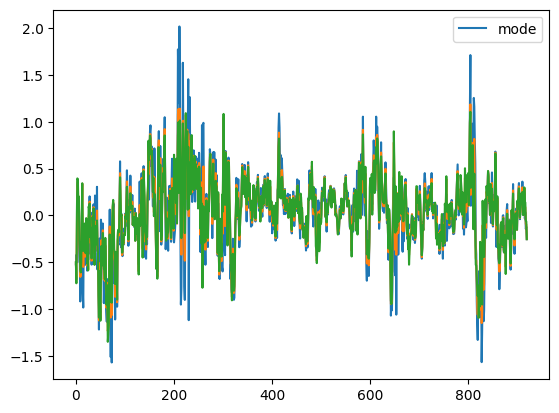

In [3]:
plt.plot(mode.cpu(), label='mode')
plt.plot(median.cpu())
plt.plot(mean)
plt.legend()
plt.show()
# На графике видно, что мода всегда перестреливает медиану

<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
/var/folders/z3/zn_785qs7q5b__3ny3cy5vc00000gn/T/ipykernel_21996/1240819378.py:25: SyntaxWarning: invalid escape sequence '\m'
  component_labels = [f'$\mu_{{{k+1}}}(t)$' for k in range(3)]


N = 5; Max ACF(1): 0.9999964237213135
N = 10; Max ACF(1): 0.929002583026886
N = 15; Max ACF(1): 0.9144154787063599
N = 20; Max ACF(1): 0.8289822340011597
N = 25; Max ACF(1): 0.8066887855529785
N = 30; Max ACF(1): 0.7832433581352234
N = 35; Max ACF(1): 0.7603382468223572
N = 40; Max ACF(1): 0.753075122833252
N = 45; Max ACF(1): 0.747492790222168
N = 50; Max ACF(1): 0.7408686876296997
N = 55; Max ACF(1): 0.7327196598052979
N = 60; Max ACF(1): 0.7162199020385742
N = 65; Max ACF(1): 0.716742753982544
N = 70; Max ACF(1): 0.7282934188842773
N = 75; Max ACF(1): 0.7070990800857544
N = 80; Max ACF(1): 0.6978131532669067
Found window length: 80
N = 5; Max ACF(1): 0.9999964237213135
N = 10; Max ACF(1): 0.929002583026886
N = 15; Max ACF(1): 0.9144154787063599
N = 20; Max ACF(1): 0.8289822340011597
N = 25; Max ACF(1): 0.8066887855529785
N = 30; Max ACF(1): 0.7832433581352234
N = 35; Max ACF(1): 0.7603382468223572
N = 40; Max ACF(1): 0.753075122833252
N = 45; Max ACF(1): 0.747492790222168
N = 50; Ma

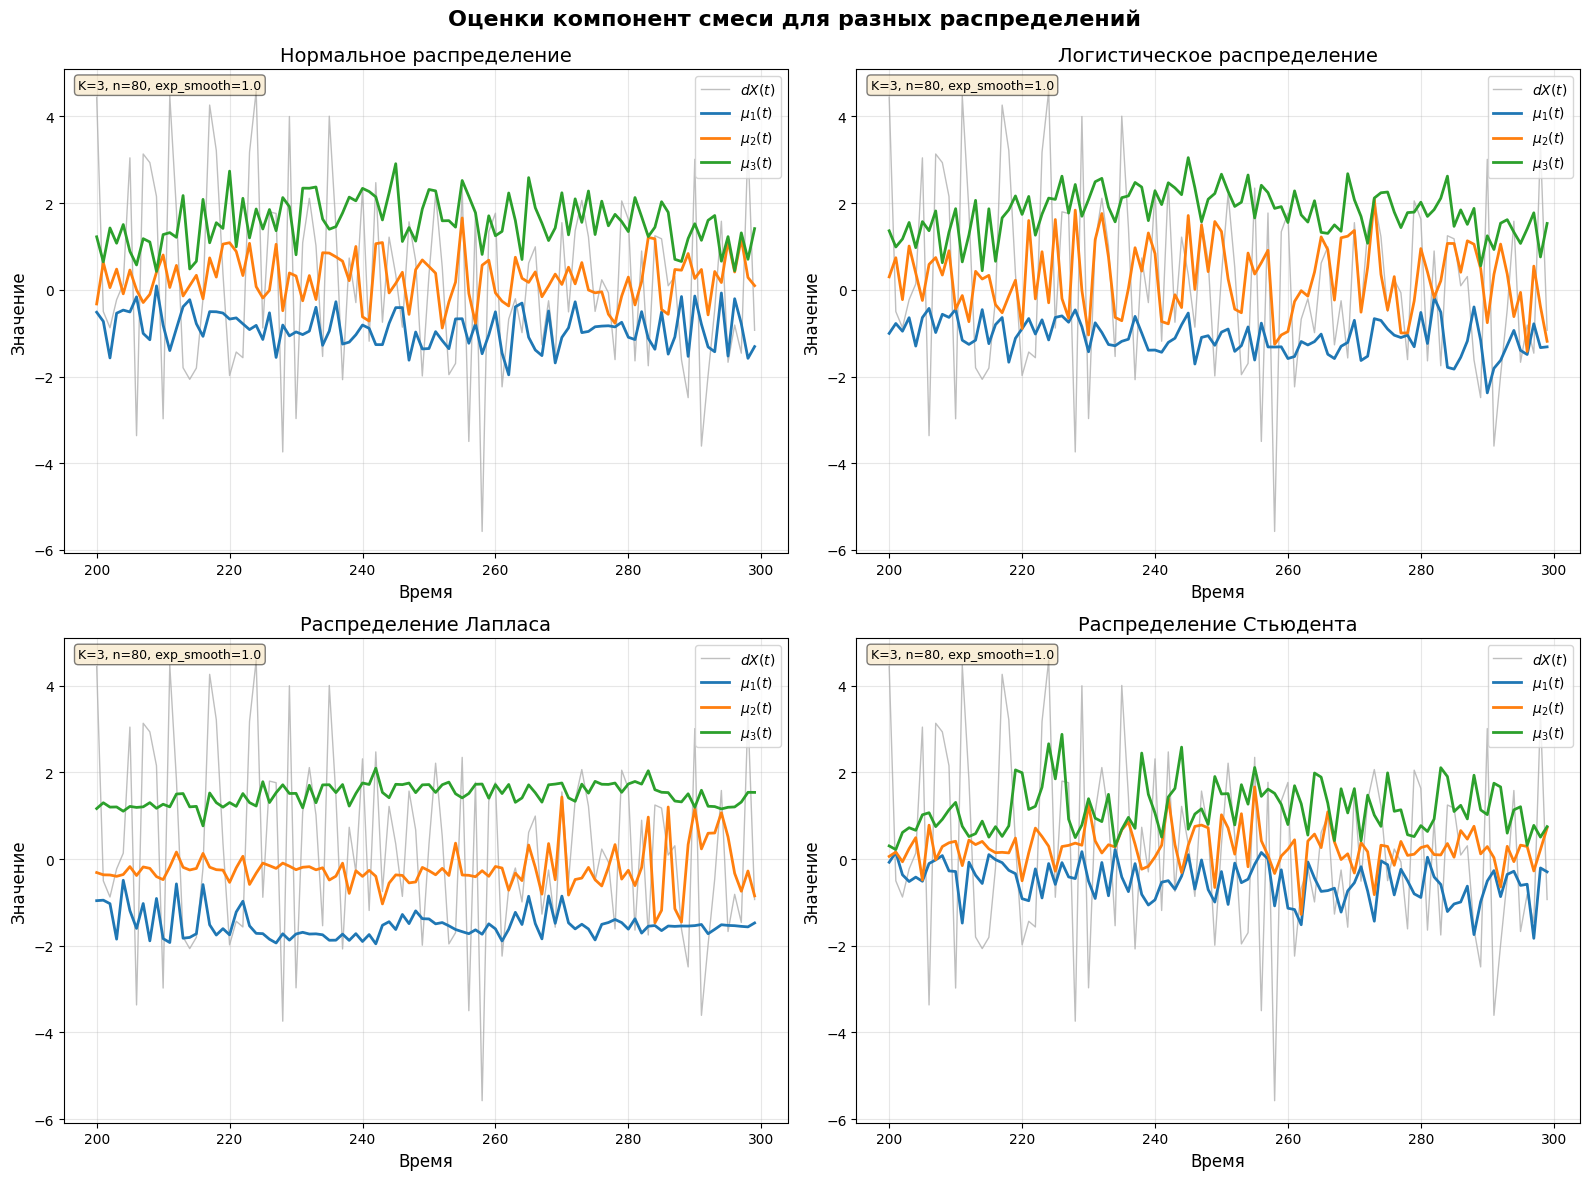

In [15]:
a_ks = []

distrs = ('normal', 'logistic', 'laplace', 'student')

for distr in distrs:
    sem = MixtureSEM(deltas, n_components=3, N_init=5, alpha=0.7, comp_distr=distr, exp_smooth=1.0, prior_strength=1.0, tol=1e-4, device="cpu")
    args = sem.find_params()

    a_ks.append(args['mu'].squeeze().cpu())


# Настройка стиля
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Оценки компонент смеси для разных распределений', fontsize=16, fontweight='bold')

# Общий временной диапазон
start = 200
finish = 300
time_axis = np.arange(start, finish)
deltas_subset = deltas[sem.series_length-1 + start:sem.series_length-1 + finish]

# Цвета для компонент
component_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # синий, оранжевый, зелёный
component_styles = ['-', '-', '-']
component_labels = [f'$\mu_{{{k+1}}}(t)$' for k in range(3)]

# Названия распределений
titles = ['Нормальное распределение', 'Логистическое распределение', 
          'Распределение Лапласа', 'Распределение Стьюдента']

for idx, (distr, mu_values) in enumerate(zip(distrs, a_ks)):
    row, col = idx // 2, idx % 2
    ax = axes[row, col]
    
    # Истинные приращения (серым фоном для контекста)
    ax.plot(time_axis, deltas_subset, color='gray', linewidth=1, 
            alpha=0.5, label='$dX(t)$', zorder=1)
    
    # Три компоненты mu_k
    for comp in range(3):
        mu_comp = mu_values[start:finish, comp]
        ax.plot(time_axis, mu_comp, color=component_colors[comp], 
                linewidth=2, linestyle=component_styles[comp],
                label=component_labels[comp], zorder=2)
    
    ax.set_title(titles[idx], fontsize=14)
    ax.set_xlabel('Время', fontsize=12)
    ax.set_ylabel('Значение', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=10)
    
    # Добавляем информацию о параметрах
    ax.text(0.02, 0.98, f'K=3, n=80, exp_smooth=1.0', transform=ax.transAxes, 
            fontsize=9, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

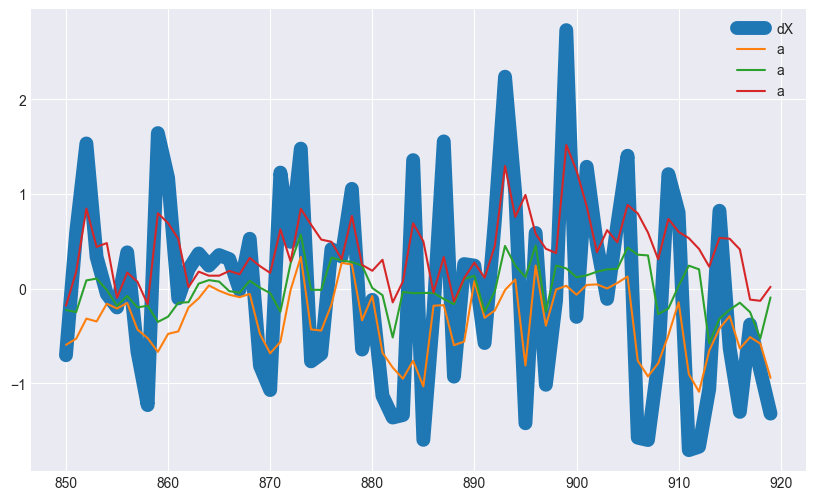

In [6]:
plt.figure(figsize=(10, 6))
start = 850
finish = 920
plt.plot(range(start, finish), deltas[sem.series_length-1 + start:sem.series_length-1 + finish], label='dX', linewidth=10)
plt.plot(range(start, finish), a_k[start:finish], label="a")
plt.legend()
plt.show()

In [7]:
p_k[start: finish], a_k[start: finish], mode[start: finish]

(tensor([[0.5718, 0.1962, 0.2320],
         [0.4240, 0.1887, 0.3872],
         [0.2146, 0.3090, 0.4764],
         [0.2215, 0.4786, 0.2999],
         [0.3749, 0.3137, 0.3114],
         [0.1876, 0.1863, 0.6261],
         [0.2708, 0.2350, 0.4941],
         [0.3636, 0.2956, 0.3407],
         [0.6013, 0.2087, 0.1900],
         [0.3335, 0.2710, 0.3955],
         [0.2493, 0.2301, 0.5206],
         [0.2410, 0.3729, 0.3861],
         [0.1818, 0.4307, 0.3875],
         [0.1818, 0.3692, 0.4490],
         [0.1972, 0.2142, 0.5887],
         [0.2466, 0.3715, 0.3819],
         [0.2074, 0.1900, 0.6026],
         [0.1843, 0.3777, 0.4380],
         [0.1818, 0.2924, 0.5258],
         [0.4124, 0.2213, 0.3663],
         [0.4754, 0.2309, 0.2938],
         [0.3695, 0.2476, 0.3829],
         [0.1829, 0.4075, 0.4096],
         [0.3448, 0.2873, 0.3679],
         [0.4065, 0.1832, 0.4103],
         [0.4995, 0.1821, 0.3184],
         [0.3076, 0.4545, 0.2379],
         [0.3667, 0.2699, 0.3634],
         [0.1904, 0.

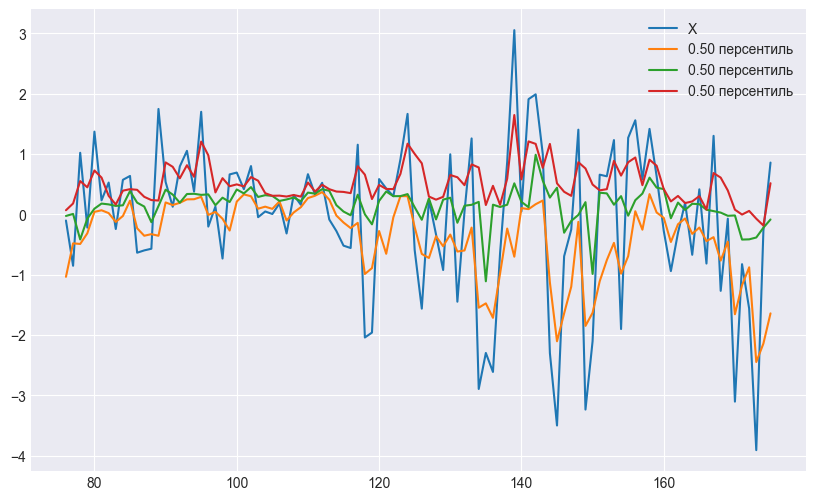

KeyboardInterrupt: 

In [8]:
%matplotlib inline

window_size = 100

for i in range(0, 100000 - window_size, 4):
    clear_output(wait=True)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(i, i+window_size), deltas[sem.series_length-1 + i:sem.series_length-1 + i + window_size], label='X')
    plt.plot(range(i, i+window_size), a_k.cpu()[i:i+window_size], label="0.50 персентиль")
    plt.legend()
    plt.show()
    sleep(0.5)

In [1]:
from sem.generate_series import create_sde_process
from sem.sem.mixture_sem import MixtureSEM
from sem.sem.mixture_em_diff import NormalMixtureEM
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep
import torch
import numpy as np
import random

<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:82: SyntaxWarning: invalid escape sequence '\h'
<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:82: SyntaxWarning: invalid escape sequence '\h'
/var/folders/z3/zn_785qs7q5b__3ny3cy5vc00000gn/T/ipykernel_24706/950201128.py:42: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(sigma[:, comp], linewidth=1.5, label=f'$\sigma_{comp+1}$')
/var/folders/z3/zn_785qs7q5b__3ny3cy5vc00000gn/T/ipykernel_24706/950201128.py:45: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('$\sigma_k(t)$', fontsize=10)
/var/folders/z3/zn_785qs7q5b__3ny3cy5vc00000gn/T/ipykernel_24706/950201128.py:82: SyntaxWarning: invalid escape sequence '\h'
  ax.set_title('Абсолютная ошибка восстановления $|b(t) - \hat{b}(t)|$', fontsize=12)


N = 5; Max ACF(1): 0.9999964237213135
N = 10; Max ACF(1): 0.929002583026886
N = 15; Max ACF(1): 0.9144154787063599
N = 20; Max ACF(1): 0.8289822340011597
N = 25; Max ACF(1): 0.8066887855529785
N = 30; Max ACF(1): 0.7832433581352234
N = 35; Max ACF(1): 0.7603382468223572
N = 40; Max ACF(1): 0.753075122833252
N = 45; Max ACF(1): 0.747492790222168
N = 50; Max ACF(1): 0.7408686876296997
N = 55; Max ACF(1): 0.7327196598052979
N = 60; Max ACF(1): 0.7162199020385742
N = 65; Max ACF(1): 0.716742753982544
N = 70; Max ACF(1): 0.7282934188842773
N = 75; Max ACF(1): 0.7070990800857544
N = 80; Max ACF(1): 0.6978131532669067
Found window length: 80
N = 5; Max ACF(1): 0.9999964237213135
N = 10; Max ACF(1): 0.929002583026886
N = 15; Max ACF(1): 0.9144154787063599
N = 20; Max ACF(1): 0.8289822340011597
N = 25; Max ACF(1): 0.8066887855529785
N = 30; Max ACF(1): 0.7832433581352234
N = 35; Max ACF(1): 0.7603382468223572
N = 40; Max ACF(1): 0.753075122833252
N = 45; Max ACF(1): 0.747492790222168
N = 50; Ma

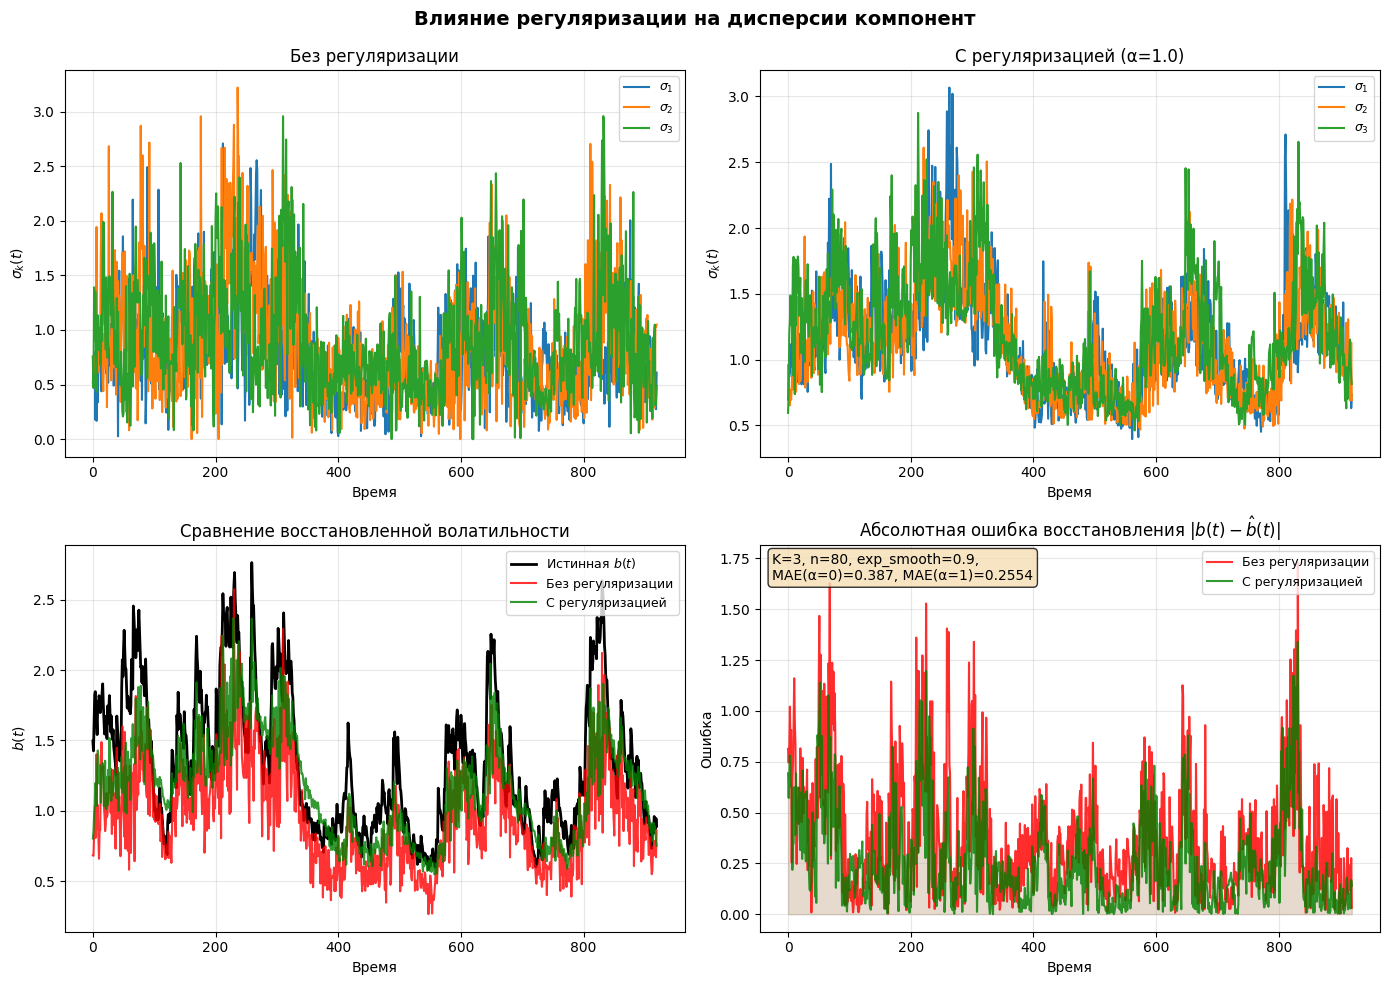

In [22]:
seed = 85
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
random.seed(seed)

num_components = 5
length = 1000

series_dct = create_sde_process(length, n_components=num_components)
series = series_dct['X']
deltas = series[1:] - series[:-1]
b_trafaret = series_dct['b_t']

distr = 'normal'

sem = MixtureSEM(deltas, n_components=3, N_init=5, alpha=0.7, comp_distr=distr, exp_smooth=0.9, prior_strength=0.0, tol=1e-4, eps=0.0, device="cpu")
args = sem.find_params()
p0_k = args['w'].squeeze()
sigma_without_regularization = args['sigma'].squeeze()

sem = MixtureSEM(deltas, n_components=3, N_init=5, alpha=0.7, comp_distr=distr, exp_smooth=0.9, prior_strength=1.0, tol=1e-4, eps=0.0, device="cpu")
args = sem.find_params()
p1_k = args['w'].squeeze()
sigma_with_regularization = args['sigma'].squeeze()



fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Влияние регуляризации на дисперсии компонент', 
             fontsize=14, fontweight='bold')

# 1-2. Дисперсии компонент (как выше)
for ax, sigma, title in zip(axes[0], 
                            [sigma_without_regularization, sigma_with_regularization],
                            ['Без регуляризации', 'С регуляризацией (α=1.0)']):
    for comp in range(3):
        ax.plot(sigma[:, comp], linewidth=1.5, label=f'$\sigma_{comp+1}$')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Время', fontsize=10)
    ax.set_ylabel('$\sigma_k(t)$', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=9)

# 3. Сравнение восстановленной волатильности
ax = axes[1, 0]
ax.plot(b_trafaret[80:], color='black', linewidth=2, label='Истинная $b(t)$')

sigma_without_regularization = torch.where(sigma_without_regularization.isnan(), 0, sigma_without_regularization)
sigma_with_regularization = torch.where(sigma_with_regularization.isnan(), 0, sigma_with_regularization)


weighted_without = np.sqrt((sigma_without_regularization**2 * p0_k.numpy()).sum(-1))
weighted_with = np.sqrt((sigma_with_regularization**2 * p1_k.numpy()).sum(-1))

ax.plot(weighted_without, color='red', linewidth=1.5, 
        linestyle='-', label='Без регуляризации', alpha=0.8)
ax.plot(weighted_with, color='green', linewidth=1.5, 
        linestyle='-', label='С регуляризацией', alpha=0.8)

ax.set_title('Сравнение восстановленной волатильности', fontsize=12)
ax.set_xlabel('Время', fontsize=10)
ax.set_ylabel('$b(t)$', fontsize=10)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=9)

# 4. Ошибка восстановления
ax = axes[1, 1]
b_true = b_trafaret[80:len(weighted_without)+80]
error_without = np.abs(weighted_without - b_true)
error_with = np.abs(weighted_with - b_true)

ax.plot(error_without, color='red', linewidth=1.5, label='Без регуляризации', alpha=0.8)
ax.plot(error_with, color='green', linewidth=1.5, label='С регуляризацией', alpha=0.8)
ax.fill_between(range(len(error_with)), 0, error_without, color='red', alpha=0.1)
ax.fill_between(range(len(error_with)), 0, error_with, color='green', alpha=0.1)

ax.set_title('Абсолютная ошибка восстановления $|b(t) - \hat{b}(t)|$', fontsize=12)
ax.set_xlabel('Время', fontsize=10)
ax.set_ylabel('Ошибка', fontsize=10)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=9)

# Добавляем статистику
mean_error_without = error_without.mean()
mean_error_with = error_with.mean()
ax.text(0.02, 0.98, f'K=3, n=80, exp_smooth=0.9,\nMAE(α=0)={mean_error_without:.3f}, MAE(α=1)={mean_error_with:.4f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

tensor(33)